In [29]:
!pip install tensorboardX

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import time

from torchvision import datasets, transforms
from tensorboardX import SummaryWriter

use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 64

np.random.seed(42)
torch.manual_seed(42)


## Dataloaders
train_dataset = datasets.MNIST('mnist_data/', train=True, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))
test_dataset = datasets.MNIST('mnist_data/', train=False, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Simple NN. You can change this if you want.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(28*28, 200)
        self.fc2 = nn.Linear(200,10)

    def forward(self, x):
        x = x.view((-1, 28*28))
        x = F.relu(self.fc(x))
        x = self.fc2(x)
        return x

class Normalize(nn.Module):
    def forward(self, x):
        return (x - 0.1307)/0.3081

# Add the data normalization as a first "layer" to the network
# this allows us to search for adverserial examples to the real image, rather than
# to the normalized image
model = nn.Sequential(Normalize(), Net())

model = model.to(device)
model.train()

Sequential(
  (0): Normalize()
  (1): Net(
    (fc): Linear(in_features=784, out_features=200, bias=True)
    (fc2): Linear(in_features=200, out_features=10, bias=True)
  )
)

In [83]:
import torch

# The last argument 'targeted' can be used to toggle between a targeted and untargeted attack.
def fgsm(model, x, target, eps, targeted=True):
    torch.manual_seed(1)
    x.requires_grad_() # this is required so we can compute the gradient w.r.t x
    L = nn.CrossEntropyLoss()
    loss = None
    if targeted:
      loss = L(model(x), torch.tensor([1 for i in range(len(target))], dtype=torch.long)) # TO LEARN: make sure you understand this line
    else:
      loss = L(model(x), target)
    loss.backward()
    sig = 1
    if targeted:      # if targeted then move away from gradient descent else move towards
      sig = -1
    adv_x = x + sig*eps*torch.sign(x.grad)
    adv_x = torch.clamp(adv_x, x-eps, x+eps)
    adv_x = torch.clamp(adv_x, 0, 1)
    return adv_x

In [49]:
def pgd_untargeted(model, x, labels, k, eps, eps_step):
    x.requires_grad_() # this is required so we can compute the gradient w.r.t x
    x_adv = x
    for i in range(k):
      L = nn.CrossEntropyLoss()
      loss = L(model(x_adv), labels) # TO LEARN: make sure you understand this line
      x_adv.retain_grad()
      loss.backward(retain_graph=True)

      x_adv = x_adv + eps_step * torch.sign(x_adv.grad)
      x_adv = torch.clamp(x_adv, x-eps, x+eps)
      x_adv = torch.clamp(x_adv, 0, 1)
    return x_adv

In [63]:
def train_model(model, num_epochs, accuracies, attack_type, enable_defense=True):
    learning_rate = 0.0001

    opt = optim.Adam(params=model.parameters(), lr=learning_rate)

    ce_loss = torch.nn.CrossEntropyLoss()

    tot_steps = 0
    for epoch in range(1,num_epochs+1):
        t1 = time.time()
        for batch_idx, (x_batch, y_batch) in enumerate(train_loader):

            if enable_defense:
                ###############################################
                # Fill code here to do adversarial training
                # You may find it useful to switch to 'eval' model while generating the attack
                # and switch back again to 'train' mode once the attack is generated.
                ###############################################
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                x_adv = pgd_untargeted(model, x_batch, y_batch, k=10, eps=0.1, eps_step=0.01)
                opt.zero_grad()
                out = model(x_adv)
                batch_loss = ce_loss(out, y_batch)
                batch_loss.backward()
                opt.step()
                model.zero_grad()

            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            tot_steps += 1
            opt.zero_grad()
            out = model(x_batch)
            batch_loss = ce_loss(out, y_batch)
            batch_loss.backward()
            opt.step()
            model.zero_grad()

        tot_test, tot_acc = 0.0, 0.0
        for batch_idx, (x_batch, y_batch) in enumerate(test_loader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            if attack_type == 'fgsm_untargeted':
              x_batch = fgsm(model, x_batch, y_batch, 0.05, False)
            if attack_type == 'fgsm_targeted':
              x_batch = fgsm(model, x_batch, y_batch, 0.05, True)
            elif attack_type == 'pgd':
              x_batch = pgd_untargeted(model, x_batch, y_batch, k=5, eps=0.1, eps_step=0.01)
            out = model(x_batch)
            pred = torch.max(out, dim=1)[1]
            acc = pred.eq(y_batch).sum().item()
            tot_acc += acc
            tot_test += x_batch.size()[0]
        accuracies.append(tot_acc)
        t2 = time.time()
        print('Epoch %d: Accuracy %.5lf [%.2lf seconds]' % (epoch, tot_acc/tot_test, t2-t1))

In [33]:
original_accuracies = []
num_epochs = 10

train_model(model, num_epochs=num_epochs, accuracies=original_accuracies, attack_type=None, enable_defense=False)

Epoch 1: Accuracy 0.91930 [16.01 seconds]
Epoch 2: Accuracy 0.93590 [13.62 seconds]
Epoch 3: Accuracy 0.94720 [10.17 seconds]
Epoch 4: Accuracy 0.95490 [9.86 seconds]
Epoch 5: Accuracy 0.95820 [9.45 seconds]
Epoch 6: Accuracy 0.96420 [10.22 seconds]
Epoch 7: Accuracy 0.96680 [10.21 seconds]
Epoch 8: Accuracy 0.96940 [10.13 seconds]
Epoch 9: Accuracy 0.97080 [11.07 seconds]
Epoch 10: Accuracy 0.97350 [9.21 seconds]


In [34]:
fgsm_attack_accuracies = []
train_model(model, num_epochs=num_epochs, accuracies=fgsm_attack_accuracies, attack_type='fgsm_untargeted', enable_defense=False)

Epoch 1: Accuracy 0.75550 [17.31 seconds]
Epoch 2: Accuracy 0.75610 [12.79 seconds]
Epoch 3: Accuracy 0.74950 [10.77 seconds]
Epoch 4: Accuracy 0.74710 [9.79 seconds]
Epoch 5: Accuracy 0.74020 [11.35 seconds]
Epoch 6: Accuracy 0.73770 [10.51 seconds]
Epoch 7: Accuracy 0.73270 [13.64 seconds]
Epoch 8: Accuracy 0.72690 [10.62 seconds]
Epoch 9: Accuracy 0.72280 [11.72 seconds]
Epoch 10: Accuracy 0.71810 [10.48 seconds]


In [35]:
pgd_attack_accuracies = []
train_model(model, num_epochs=num_epochs, accuracies=pgd_attack_accuracies, attack_type='pgd', enable_defense=False)

Epoch 1: Accuracy 0.69180 [13.44 seconds]
Epoch 2: Accuracy 0.69500 [13.83 seconds]
Epoch 3: Accuracy 0.68230 [13.33 seconds]
Epoch 4: Accuracy 0.67880 [13.36 seconds]
Epoch 5: Accuracy 0.68960 [13.53 seconds]
Epoch 6: Accuracy 0.66220 [13.20 seconds]
Epoch 7: Accuracy 0.63650 [13.40 seconds]
Epoch 8: Accuracy 0.64700 [13.90 seconds]
Epoch 9: Accuracy 0.64540 [13.75 seconds]
Epoch 10: Accuracy 0.64260 [14.08 seconds]


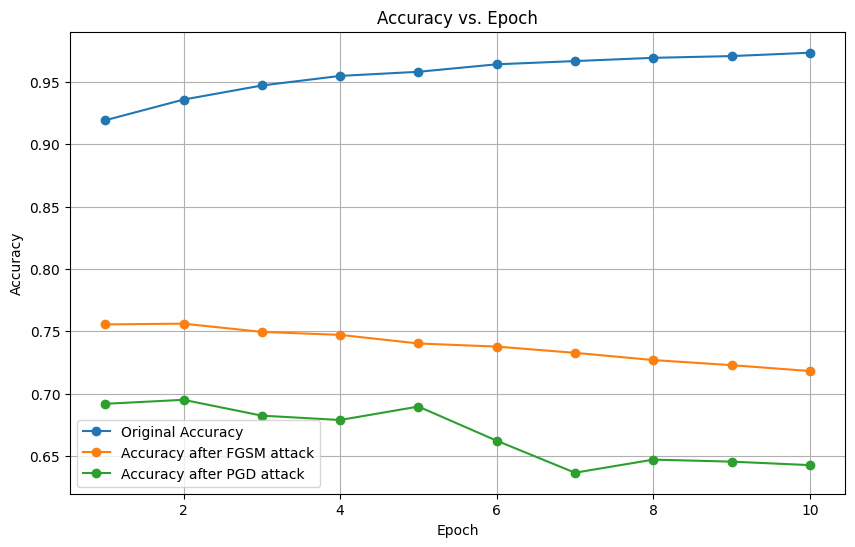

In [36]:
import matplotlib.pyplot as plt

epochs = [i for i in range(1, num_epochs+1)]
plt.figure(figsize=(10, 6))

original_accuracies = [i/10000 for i in original_accuracies]
fgsm_attack_accuracies = [i/10000 for i in fgsm_attack_accuracies]
pgd_attack_accuracies = [i/10000 for i in pgd_attack_accuracies]

plt.plot(epochs, original_accuracies, marker='o', linestyle='-', label='Original Accuracy')
plt.plot(epochs, fgsm_attack_accuracies, marker='o', linestyle='-', label='Accuracy after FGSM attack')
plt.plot(epochs, pgd_attack_accuracies, marker='o', linestyle='-', label='Accuracy after PGD attack')

plt.title('Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.show()


In [37]:
accuracies_after_adv_training = []
train_model(model, num_epochs=num_epochs, accuracies=accuracies_after_adv_training, attack_type=None, enable_defense=True)

Epoch 1: Accuracy 0.97510 [99.04 seconds]
Epoch 2: Accuracy 0.97700 [106.83 seconds]
Epoch 3: Accuracy 0.97820 [92.91 seconds]
Epoch 4: Accuracy 0.97990 [92.61 seconds]
Epoch 5: Accuracy 0.97960 [90.32 seconds]
Epoch 6: Accuracy 0.97990 [90.83 seconds]
Epoch 7: Accuracy 0.98050 [89.94 seconds]
Epoch 8: Accuracy 0.98060 [90.88 seconds]
Epoch 9: Accuracy 0.98240 [89.75 seconds]
Epoch 10: Accuracy 0.98200 [90.47 seconds]


In [84]:
fgsm_attack_accuracies_after_training = []
train_model(model, num_epochs=num_epochs, accuracies=fgsm_attack_accuracies_after_training, attack_type='fgsm_untargeted', enable_defense=False)

Epoch 1: Accuracy 0.85660 [10.26 seconds]
Epoch 2: Accuracy 0.85620 [10.52 seconds]
Epoch 3: Accuracy 0.85560 [10.40 seconds]
Epoch 4: Accuracy 0.85450 [11.17 seconds]
Epoch 5: Accuracy 0.85340 [10.48 seconds]
Epoch 6: Accuracy 0.85290 [10.59 seconds]
Epoch 7: Accuracy 0.85200 [9.47 seconds]
Epoch 8: Accuracy 0.85210 [10.19 seconds]
Epoch 9: Accuracy 0.85210 [10.14 seconds]
Epoch 10: Accuracy 0.85390 [10.30 seconds]


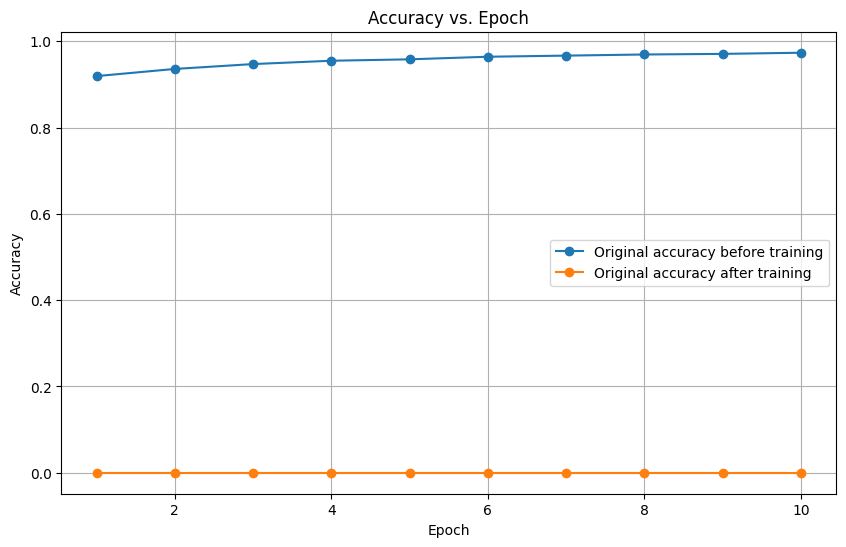

In [71]:
import matplotlib.pyplot as plt

epochs = [i for i in range(1, num_epochs+1)]
plt.figure(figsize=(10, 6))

accuracies_after_adv_training = [i/10000 for i in accuracies_after_adv_training]
plt.plot(epochs, original_accuracies, marker='o', linestyle='-', label='Original accuracy before training')
plt.plot(epochs, accuracies_after_adv_training, marker='o', linestyle='-', label='Original accuracy after training')

plt.title('Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.show()


In [64]:
fgsm_targeted_accuracies_after_training = []
train_model(model, num_epochs=num_epochs, accuracies=fgsm_targeted_accuracies_after_training, attack_type='fgsm_targeted', enable_defense=False)

Epoch 1: Accuracy 0.96100 [11.96 seconds]
Epoch 2: Accuracy 0.96150 [11.01 seconds]
Epoch 3: Accuracy 0.96060 [12.34 seconds]
Epoch 4: Accuracy 0.95980 [11.02 seconds]
Epoch 5: Accuracy 0.95900 [15.60 seconds]
Epoch 6: Accuracy 0.95910 [13.17 seconds]
Epoch 7: Accuracy 0.95770 [14.24 seconds]
Epoch 8: Accuracy 0.95760 [14.79 seconds]
Epoch 9: Accuracy 0.95720 [10.64 seconds]
Epoch 10: Accuracy 0.95750 [11.38 seconds]


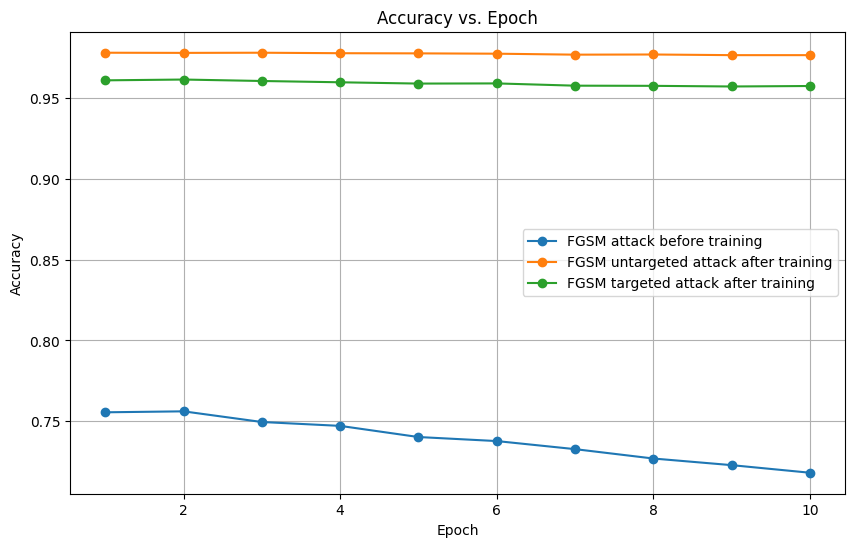

In [80]:
import matplotlib.pyplot as plt

epochs = [i for i in range(1, num_epochs+1)]
plt.figure(figsize=(10, 6))

fgsm_attack_accuracies_after_training = [i/10000 for i in fgsm_attack_accuracies_after_training]
fgsm_targeted_accuracies_after_training = [i/10000 for i in fgsm_targeted_accuracies_after_training]

plt.plot(epochs, fgsm_attack_accuracies, marker='o', linestyle='-', label='FGSM attack before training')
plt.plot(epochs, fgsm_attack_accuracies_after_training, marker='o', linestyle='-', label='FGSM untargeted attack after training')
plt.plot(epochs, fgsm_targeted_accuracies_after_training, marker='o', linestyle='-', label='FGSM targeted attack after training')

plt.title('Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.show()


In [76]:
fgsm_attack_accuracies



[0.7555,
 0.7561,
 0.7495,
 0.7471,
 0.7402,
 0.7377,
 0.7327,
 0.7269,
 0.7228,
 0.7181]

In [77]:
fgsm_attack_accuracies_after_training

[9781.0,
 9780.0,
 9781.0,
 9778.0,
 9777.0,
 9775.0,
 9769.0,
 9770.0,
 9766.0,
 9766.0]

In [79]:
fgsm_targeted_accuracies_after_training

[9610.0,
 9615.0,
 9606.0,
 9598.0,
 9590.0,
 9591.0,
 9577.0,
 9576.0,
 9572.0,
 9575.0]